In [3]:
from functools import partial
import random
from hashlib import md5
rng = random.Random(42)

def get_prompts(row, rng):
    hard_label = int(rng.random() < 0.5)
    if hard_label:
        ans = row["choices"][int(row["answer"])]
    else:
        ans = rng.choice(
            [c for i, c in enumerate(row["choices"]) if i != int(row["answer"])]
        )

    choices = "\n".join(row["choices"])
    txt = f"{row['question']}\n\n{choices}\n\nA: {ans}."
    completion = {"prompt": txt, "completion": " Yes" if hard_label else " No"}
    messages = {"messages": [
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": txt},
        {"role": "assistant", "content": "Yes" if hard_label else "No"},
    ]}
    return {"id": md5(txt.encode()).hexdigest()[-8:], "messages": messages, "completion": completion, "hard_label": hard_label}

In [3]:
# load MMLU, splitting it into a train and test set
# train a weak model (e.g. babbage)
# get predictions on train and test (including logprobs)
# save these predictions
# shuffle train and get a val set
# train a 4o on the train set, early stopping on val set
# get predictions on test set, including logprobs
# get accuracy on test set and save the num_weak, num_strong, num_epochs, val_acc, test_acc, and predictions
from datasets import load_dataset, concatenate_datasets

ds = load_dataset("cais/mmlu", "all")

/home/alex/.conda/envs/w2s2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
ds = concatenate_datasets([ds["test"], ds["validation"], ds["dev"]])
ds

Dataset({
    features: ['question', 'subject', 'choices', 'answer'],
    num_rows: 15858
})

In [5]:
binary_ds = ds.map(partial(get_prompts, rng=rng))
binary_ds


Dataset({
    features: ['question', 'subject', 'choices', 'answer', 'id', 'messages', 'completion', 'hard_label'],
    num_rows: 15858
})

In [6]:
# split into train and test
splits = binary_ds.shuffle(seed=0).train_test_split(test_size=1000/len(binary_ds))
subsplits = splits["train"].train_test_split(test_size=500/len(splits["train"]))
splits = {
    "train": subsplits["train"],
    "val": subsplits["test"],
    "test": splits["test"],
}

In [36]:
# save jsonls
import json

for split_name, split in splits.items():
    with open(f"openai/{split_name}.jsonl", "w") as f:
        f.write("\n".join([json.dumps(d) for d in split["completion"]]))

n = 3000
small_train = splits["train"].select(range(n))
with open(f"openai/train{n}.jsonl", "w") as f:
    f.write("\n".join([json.dumps(d) for d in small_train["completion"]]))


# finetune weak model

In [1]:
from openai import OpenAI

client = OpenAI()

In [38]:
client.files.create(
    file=open(f"openai/train{n}.jsonl", "rb"),
    purpose="fine-tune"
)

FileObject(id='file-VJuHa1O8tYpZiBPl00RhZuW6', bytes=1654821, created_at=1723226415, filename='train3000.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

In [39]:
client.files.create(
    file=open("openai/val.jsonl", "rb"),
    purpose="fine-tune"
)

FileObject(id='file-DpbDksSRdN0GSu3EzKbTEKte', bytes=266589, created_at=1723226420, filename='val.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

In [40]:
import wandb

client.fine_tuning.jobs.create(
  training_file="file-VJuHa1O8tYpZiBPl00RhZuW6",
  validation_file="file-GTrAajQvRCfpmyc52o6vtRxh",
  model="davinci-002",
  suffix = "davinci-mmlu",
  integrations=[{"type": "wandb", "wandb": {"project": "openai-sft"}}]
)

FineTuningJob(id='ftjob-qNsCRUUZU726tnqnTqncnrPs', created_at=1723226442, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs='auto', batch_size='auto', learning_rate_multiplier='auto'), model='davinci-002', object='fine_tuning.job', organization_id='org-5KzWCdbJZtVYV7zk2r3Ekq9H', result_files=[], seed=789730328, status='validating_files', trained_tokens=None, training_file='file-VJuHa1O8tYpZiBPl00RhZuW6', validation_file='file-GTrAajQvRCfpmyc52o6vtRxh', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='openai-sft', entity=None, name=None, tags=None, run_id='ftjob-qNsCRUUZU726tnqnTqncnrPs'))], user_provided_suffix='davinci-mmlu')

In [30]:
client.fine_tuning.jobs.list(limit=10)

SyncCursorPage[FineTuningJob](data=[FineTuningJob(id='ftjob-SX87lGJ0rqQckmxTfD0rMuix', created_at=1723225303, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs='auto', batch_size='auto', learning_rate_multiplier='auto'), model='davinci-002', object='fine_tuning.job', organization_id='org-5KzWCdbJZtVYV7zk2r3Ekq9H', result_files=[], seed=165571620, status='validating_files', trained_tokens=None, training_file='file-tooC3SBdzF2CcZ5Kr9FTlPCl', validation_file='file-GTrAajQvRCfpmyc52o6vtRxh', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='openai-sft', entity=None, name=None, tags=None, run_id='ftjob-SX87lGJ0rqQckmxTfD0rMuix'))], user_provided_suffix='davinci-mmlu'), FineTuningJob(id='ftjob-RH2Vluya5TCK6C0jytfBO64g', created_at=1723224466, error=Error(code=None, message=None, param=None), fine_tuned_model='ft:babbage-002:person

In [42]:
client.fine_tuning.jobs.retrieve("ftjob-qNsCRUUZU726tnqnTqncnrPs")

FineTuningJob(id='ftjob-qNsCRUUZU726tnqnTqncnrPs', created_at=1723226442, error=Error(code=None, message=None, param=None), fine_tuned_model='ft:davinci-002:personal:davinci-mmlu:9uOQmMSZ', finished_at=1723227307, hyperparameters=Hyperparameters(n_epochs=3, batch_size=6, learning_rate_multiplier=16), model='davinci-002', object='fine_tuning.job', organization_id='org-5KzWCdbJZtVYV7zk2r3Ekq9H', result_files=['file-c9s40uQYHtsT5R0ibAlnwxWP'], seed=789730328, status='succeeded', trained_tokens=980784, training_file='file-VJuHa1O8tYpZiBPl00RhZuW6', validation_file='file-GTrAajQvRCfpmyc52o6vtRxh', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='openai-sft', entity=None, name=None, tags=None, run_id='ftjob-qNsCRUUZU726tnqnTqncnrPs'))], user_provided_suffix='davinci-mmlu')

In [41]:
print(client.fine_tuning.jobs.list_events(fine_tuning_job_id="ftjob-qNsCRUUZU726tnqnTqncnrPs", limit=100))

SyncCursorPage[FineTuningJobEvent](data=[FineTuningJobEvent(id='ftevent-QPTezqVW75EVnN02wlYNw9b0', created_at=1723227314, level='info', message='The job has successfully completed', object='fine_tuning.job.event', data={}, type='message'), FineTuningJobEvent(id='ftevent-ZE3G9B2IZ6fjW51pfG697aTL', created_at=1723227309, level='info', message='New fine-tuned model created: ft:davinci-002:personal:davinci-mmlu:9uOQmMSZ', object='fine_tuning.job.event', data={}, type='message'), FineTuningJobEvent(id='ftevent-EZ9phB97w8n2rliakGZB58HC', created_at=1723227309, level='info', message='Checkpoint created at step 1000 with Snapshot ID: ft:davinci-002:personal:davinci-mmlu:9uOQmN75:ckpt-step-1000', object='fine_tuning.job.event', data={}, type='message'), FineTuningJobEvent(id='ftevent-0FdaPaT9rnhCfJ6If71SlT4X', created_at=1723227309, level='info', message='Checkpoint created at step 500 with Snapshot ID: ft:davinci-002:personal:davinci-mmlu:9uOQmZP2:ckpt-step-500', object='fine_tuning.job.event'

# Do inference on, train, val, and test sets

In [7]:
import numpy as np
from openai import AsyncOpenAI
import asyncio


client = AsyncOpenAI(api_key=key)

async def completions_inference(row, model_id, num_tries=5):
    for _ in range(num_tries):
        try:
            resp = await client.completions.create(
                model=model_id,
                prompt=row["completion"]["prompt"],
                temperature=0.0,
                max_tokens=1,
                top_p=1.0,
                frequency_penalty=0.0,
                presence_penalty=0.0,
                logprobs=2,
            )
            logrpobs = resp.choices[0].logprobs.top_logprobs[0]
            if set(logrpobs.keys()) != {" Yes", " No"}:
                print(f"Warning: logprobs keys are {logrpobs.keys()}")
            
            
            p = np.exp(logrpobs.get(" Yes", -100)) / (np.exp(logrpobs.get(" Yes", -100)) + np.exp(logrpobs.get(" No", -100)))
            return p
        except Exception as e:
            print(f"Error: {e}")
            await asyncio.sleep(15)
            continue

weak_model_id = "ft:davinci-002:personal:davinci-mmlu:9uOQmMSZ"
split_name = "train"
batch_size = 100
split_ps_all = []
for i in range(0, len(splits[split_name]), batch_size):
    print(f"Processing batch {i//batch_size} of {len(splits[split_name])//batch_size}")
    end = min(i + batch_size, len(splits[split_name]))
    split_ps = await asyncio.gather(*[completions_inference(row, weak_model_id) for row in splits[split_name].select(range(i, end))])
    print(f"Batch {i//batch_size} done")
    await asyncio.sleep(10)
    split_ps_all.extend(split_ps)
splits[split_name] = splits[split_name].add_column("weak_prob", split_ps_all)

Processing batch 0 of 143
Batch 0 done
Processing batch 100 of 143
Batch 100 done
Processing batch 200 of 143
Batch 200 done
Processing batch 300 of 143
Batch 300 done
Processing batch 400 of 143
Batch 400 done
Processing batch 500 of 143
Batch 500 done
Processing batch 600 of 143
Batch 600 done
Processing batch 700 of 143
Batch 700 done
Processing batch 800 of 143
Batch 800 done
Processing batch 900 of 143
Batch 900 done
Processing batch 1000 of 143
Batch 1000 done
Processing batch 1100 of 143
Batch 1100 done
Processing batch 1200 of 143
Batch 1200 done
Processing batch 1300 of 143
Batch 1300 done
Processing batch 1400 of 143
Batch 1400 done
Processing batch 1500 of 143
Batch 1500 done
Processing batch 1600 of 143
Batch 1600 done
Processing batch 1700 of 143
Batch 1700 done
Processing batch 1800 of 143
Batch 1800 done
Processing batch 1900 of 143
Batch 1900 done
Processing batch 2000 of 143
Batch 2000 done
Processing batch 2100 of 143
Batch 2100 done
Processing batch 2200 of 143
Batch

Flattening the indices: 100%|██████████| 14358/14358 [00:01<00:00, 8283.63 examples/s]


In [9]:
splits[split_name].save_to_disk(f"openai/weak_{split_name}")
splits[split_name]

Saving the dataset (1/1 shards): 100%|██████████| 14358/14358 [00:00<00:00, 650519.22 examples/s]


Dataset({
    features: ['question', 'subject', 'choices', 'answer', 'id', 'messages', 'completion', 'hard_label', 'weak_prob'],
    num_rows: 14358
})

# Train 4o on weak labels

In [4]:
# for this step use openai_weak_sft.py instead, to do keep trying requests until there is no more rate limit error

In [5]:
weak_marginal_costs = [1 / 10]
oracle_spending_fracs = [0.0, 0.05, 0.5, 0.95, 1.0]
oracle_affordables = [16, 64, 256, 1024, 4096]

pairs = []
for weak_marginal_cost in weak_marginal_costs:
    for oracle_affordable in oracle_affordables:
        accs = []
        actual_osfs = []
        for osf in oracle_spending_fracs:
            n_oracle = int(osf * oracle_affordable)
            n_weak = int(
                (oracle_affordable - n_oracle) / weak_marginal_cost
            )
            n_oracle = min(n_oracle, 23_000)
            pairs.append((n_weak, n_oracle))
pairs.append((0, 8192))
pairs = list(set(pairs))
pairs

[(160, 0),
 (2440, 12),
 (1280, 128),
 (130, 243),
 (10240, 0),
 (0, 1024),
 (40, 60),
 (9730, 51),
 (10, 15),
 (0, 4096),
 (40960, 0),
 (20480, 2048),
 (38920, 204),
 (0, 16),
 (2560, 0),
 (0, 8192),
 (80, 8),
 (5120, 512),
 (610, 3),
 (0, 64),
 (320, 32),
 (640, 0),
 (0, 256),
 (2050, 3891),
 (520, 972)]

In [8]:
import os
import json


def upload_files(is_weak, num_weak, num_oracle, num_test, source_dict):
    weak_oracle = "weak" if is_weak else "oracle"
    name = f"{num_weak}-{num_oracle}-{weak_oracle}"
    shuffled_train = source_dict["train"].shuffle(seed=0)
    weak = shuffled_train.select(range(num_weak))
    oracle = shuffled_train.select(range(num_weak, num_weak + num_oracle))
    train = weak if is_weak else oracle
    if is_weak:
        train = train.add_column("label", (np.array(train["weak_prob"]) > 0.5).astype(int).tolist())  # type: ignore
    else:
        train = train.add_column("label", train["hard_label"])  # type: ignore

    def modify_messages(ex, mes_choices=["No", "Yes"], compl_choices=[" No", " Yes"]):
        """
        Modify the messages to have the requested label
        """
        label = mes_choices[ex["label"]]
        mes = ex["messages"]["messages"][-1]
        assert mes["role"] == "assistant"
        assert mes["content"] in mes_choices
        mes["content"] = label
        ex["completion"]["completion"] = compl_choices[ex["label"]]
        return ex

    train = train.map(modify_messages)

    test = source_dict["test"].shuffle(seed=0).select(range(num_test))

    os.makedirs(f"openai/{name}", exist_ok=True)
    with open(f"openai/{name}/{weak_oracle}_train.jsonl", "w") as f:
        f.write("\n".join([json.dumps(d) for d in train["messages"]]))
    with open(f"openai/{name}/{weak_oracle}_test.jsonl", "w") as f:
        f.write("\n".join([json.dumps(d) for d in test["messages"]]))

    train_file = client.files.create(
        file=open(f"openai/{name}/{weak_oracle}_train.jsonl", "rb"),
        purpose="fine-tune"
    )
    test_file = client.files.create(
        file=open(f"openai/{name}/{weak_oracle}_test.jsonl", "rb"),
        purpose="fine-tune"
    )
    return train_file, test_file, name

In [10]:
from datasets import DatasetDict, concatenate_datasets, load_from_disk
import numpy as np
from openai import OpenAI

num_test = 1000

splits = dict()
for split in ["train", "val", "test"]:
    splits[split] = load_from_disk(f"openai/weak_{split}")
weak_dict = DatasetDict({
    "train": concatenate_datasets([splits["train"], splits["val"]]).shuffle(seed=0),
    "test": splits["test"],
})

client = OpenAI(api_key=key)

In [11]:
from openai import RateLimitError
import time

with open("openai/jobs.json", "r") as f:
    jobs = json.load(f)
for num_weak, num_oracle in pairs:
    if num_weak == 0:
        continue
    if f"{num_weak}-{num_oracle}-weak" in jobs:
        continue
    train_file, test_file, name = upload_files(True, num_weak, num_oracle, num_test, weak_dict)
    while True:
        try:
            job = client.fine_tuning.jobs.create(
                training_file=train_file.id,
                validation_file=test_file.id,
                model="gpt-4o-mini-2024-07-18",
                suffix=name,
                integrations=[{"type": "wandb", "wandb": {"project": "openai-sft"}}]
            )
            job_id = job.id
            jobs[name] = {
                "job": json.loads(job.model_dump_json()),
                "train_file_id": train_file.id,
                "val_file_id": test_file.id,
            }
            break
        except RateLimitError as e:
            print(f"Rate limit error at {time.time()}")
            time.sleep(120)
            continue
        except Exception as e:
            print(f"Error: {e}")
            
            time.sleep(120)
            continue
    with open("openai/jobs.json", "w") as f:
        f.write(json.dumps(jobs))

Map: 100%|██████████| 130/130 [00:00<00:00, 7311.07 examples/s]


RateLimitError: Error code: 429 - {'error': {'message': "This fine-tune request has been rate-limited. Your organization has reached the maximum of 3 active requests (0 running, 3 pending) for the model 'gpt-4o-mini-2024-07-18'.", 'type': 'invalid_request_error', 'param': None, 'code': 'rate_limit_exceeded'}}

In [27]:
import time

job_id = "ftjob-OyNVI9Se55CsMXf2DjzwWxSY"
while True:
    status = client.fine_tuning.jobs.retrieve("ftjob-OyNVI9Se55CsMXf2DjzwWxSY").status
    if status == "succeeded":
        break
    elif status in ["failed", "cancelled"]:
        raise Exception(f"Job {job_id} failed with status {status}")
    time.sleep(10)
intermediate_model = client.fine_tuning.jobs.retrieve(fine_tuning_job_id=job_id).fine_tuned_model

In [8]:
checkpoint_events = [e for e in events if e.type == "metrics" and "full_valid_mean_token_accuracy" in e.data]
best_event = max(checkpoint_events, key=lambda x: x.data["full_valid_mean_token_accuracy"])
best_step = best_event.data["step"]
best_step

416

In [9]:
import requests

response = requests.get(f"https://api.openai.com/v1/fine_tuning/jobs/{job_id}/checkpoints?step={best_step}", headers={"Authorization": f"Bearer {key}"})
print(response.json())
best_checkpoint = [obj["fine_tuned_model_checkpoint"] for obj in response.json()["data"] if obj["step_number"] == best_step][0]
best_checkpoint


{'object': 'list', 'data': [{'object': 'fine_tuning.job.checkpoint', 'id': 'ftckpt_Qt335bmw9mdMO8bPzWLWKs3I', 'created_at': 1723313453, 'fine_tuned_model_checkpoint': 'ft:gpt-4o-mini-2024-07-18:personal:520-972:9ukr4Nd7', 'fine_tuning_job_id': 'ftjob-OyNVI9Se55CsMXf2DjzwWxSY', 'metrics': {'step': 1248, 'train_loss': 0.00012715657067019492, 'train_mean_token_accuracy': 1.0}, 'step_number': 1248}, {'object': 'fine_tuning.job.checkpoint', 'id': 'ftckpt_6foiSRNnyaAkzUjrXNQYvNod', 'created_at': 1723312926, 'fine_tuned_model_checkpoint': 'ft:gpt-4o-mini-2024-07-18:personal:520-972:9ukr4E6S:ckpt-step-832', 'fine_tuning_job_id': 'ftjob-OyNVI9Se55CsMXf2DjzwWxSY', 'metrics': {'step': 832, 'train_loss': 0.0016434987774118781, 'train_mean_token_accuracy': 1.0}, 'step_number': 832}, {'object': 'fine_tuning.job.checkpoint', 'id': 'ftckpt_Tn68bRzm4XEL9Dh9V0zRKLXQ', 'created_at': 1723312386, 'fine_tuned_model_checkpoint': 'ft:gpt-4o-mini-2024-07-18:personal:520-972:9ukr30LM:ckpt-step-416', 'fine_tunin

'ft:gpt-4o-mini-2024-07-18:personal:520-972:9ukr30LM:ckpt-step-416'

# Now do oracle training

In [ ]:
oracle_train_file, oracle_val_file, name = upload_files(False, num_weak, num_oracle, weak_dict)

In [23]:
job = client.fine_tuning.jobs.create(
    training_file=train_file.id,
    validation_file=val_file.id,
    model="ft:gpt-4o-mini-2024-07-18:personal:520-972:9ukr4Nd7", #best_checkpoint,
    suffix=name,
    integrations=[{"type": "wandb", "wandb": {"project": "openai-sft"}}]
)
job_id = job.id


In [41]:
events = client.fine_tuning.jobs.list_events(fine_tuning_job_id="ftjob-MeiOEIOVCHaJA1w8ukUgqDv1", limit=100)
checkpoint_events = [e for e in events if e.type == "metrics" and "full_valid_mean_token_accuracy" in e.data]
checkpoint_events

[FineTuningJobEvent(id='ftevent-IVEuA8CfV3pwfoSAG2w0MiNC', created_at=1723417884, level='info', message='Step 1556/2334: training loss=0.00, full validation loss=0.65', object='fine_tuning.job.event', data={'step': 1556, 'train_loss': 0.00031216940260492265, 'total_steps': 2334, 'full_valid_loss': 0.647935629710299, 'train_mean_token_accuracy': 1.0, 'full_valid_mean_token_accuracy': 0.9123711340206185}, type='metrics'),
 FineTuningJobEvent(id='ftevent-zE0F3XTolHRkGBXLVAneyOKy', created_at=1723416938, level='info', message='Step 778/2334: training loss=0.00, full validation loss=0.44', object='fine_tuning.job.event', data={'step': 778, 'train_loss': 0.0027147929649800062, 'total_steps': 2334, 'full_valid_loss': 0.43753366044296843, 'train_mean_token_accuracy': 1.0, 'full_valid_mean_token_accuracy': 0.9312714776632303}, type='metrics')]

In [23]:
events = client.fine_tuning.jobs.list_events(fine_tuning_job_id=job_id, limit=100)
final_acc = [e for e in events if e.type == "metrics" and "full_valid_mean_token_accuracy" in e.data][0].data["full_valid_mean_token_accuracy"]

{'id': 'ftjob-wTTXu4HEhFKZ2WQ7U1zdvOCB',
 'created_at': 1723420121,
 'error': {'code': None, 'message': None, 'param': None},
 'fine_tuned_model': None,
 'finished_at': None,
 'hyperparameters': {'n_epochs': 'auto',
  'batch_size': 'auto',
  'learning_rate_multiplier': 'auto'},
 'model': 'gpt-4o-mini-2024-07-18',
 'object': 'fine_tuning.job',
 'organization_id': 'org-5KzWCdbJZtVYV7zk2r3Ekq9H',
 'result_files': [],
 'seed': 1654820938,
 'status': 'validating_files',
 'trained_tokens': None,
 'training_file': 'file-xpxSP83JHNhxk3G2YPNo5oO9',
 'validation_file': 'file-C1AUWuwqZZE4a3MuyCjvY0k2',
 'estimated_finish': None,
 'integrations': [{'type': 'wandb',
   'wandb': {'project': 'openai-sft',
    'entity': None,
    'name': None,
    'tags': None,
    'run_id': 'ftjob-wTTXu4HEhFKZ2WQ7U1zdvOCB'}}],
 'user_provided_suffix': '1280-128-weak'}

# Gather the results

In [6]:
from openai import Client
import json

client = Client()

with open("openai/jobs.json", "r") as f:
    jobs = json.load(f)

# runs = []
run_names = [r["name"] for r in runs]
for name in jobs:
    if name.endswith("weak") or name in run_names:
        continue
    try:
        job_id = jobs[name].get("job", jobs[name].get("weak_job"))["id"]
        job = client.fine_tuning.jobs.retrieve(fine_tuning_job_id=job_id)
        events = client.fine_tuning.jobs.list_events(fine_tuning_job_id=job_id, limit=10)
        final_acc = [e.data["full_valid_mean_token_accuracy"] for e in events if e.type == "metrics" and "full_valid_mean_token_accuracy" in e.data][0]
    except Exception as e:
        print(f"Error: {e}")
        continue
    if job.status == "succeeded":
        runs.append({
            "name": name,
            "job": job,
            "final_acc": final_acc,
        })
    print(f"{name}: {job.status}")
runs

Error: list index out of range
640-0-oracle: running
Error: list index out of range


[{'name': '160-0-oracle',
  'job': FineTuningJob(id='ftjob-VrKEiEMvcU8zEIkOS8OgTCbB', created_at=1723420111, error=Error(code=None, message=None, param=None), fine_tuned_model='ft:gpt-4o-mini-2024-07-18:personal:160-0-weak:9vCrKxJH', finished_at=1723421152, hyperparameters=Hyperparameters(n_epochs=3, batch_size=1, learning_rate_multiplier=1.8), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-5KzWCdbJZtVYV7zk2r3Ekq9H', result_files=['file-Hf306ES5JGvPZ4VXIzAhAf10'], seed=1178864727, status='succeeded', trained_tokens=55092, training_file='file-lDqwvokl7PFqLaQUCysvooSC', validation_file='file-3vax98DB89wuM1rmPmlNbb8N', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='openai-sft', entity=None, name=None, tags=None, run_id='ftjob-VrKEiEMvcU8zEIkOS8OgTCbB'))], user_provided_suffix='160-0-weak'),
  'final_acc': 0.9156666666666666},
 {'name': '2440-12-oracle',
  'job': FineTuningJ

In [10]:
import pandas as pd
runs_df = pd.DataFrame(runs)
runs_df

,name,job,final_acc
0,160-0-oracle,FineTuningJob(id='ftjob-VrKEiEMvcU8zEIkOS8OgTC...,0.915667
1,2440-12-oracle,FineTuningJob(id='ftjob-YsthpJm1nbZH4WDL71hsSu...,0.905000
2,1280-128-oracle,FineTuningJob(id='ftjob-ThXTZNcchvIyR4BkLNKy58...,0.915333
3,130-243-oracle,FineTuningJob(id='ftjob-GWJFdNFNk5jKBbIqwI3i5s...,0.926333
4,10240-0-oracle,FineTuningJob(id='ftjob-t3YzlZAzHScVZsZxo7ghHG...,0.899000
5,0-1024-oracle,FineTuningJob(id='ftjob-C2OcfwlDVq5bBL1LfcfD9N...,0.939000
6,40-60-oracle,FineTuningJob(id='ftjob-0uyBaznP1xoObwX4x9JGUU...,0.918333
7,9730-51-oracle,FineTuningJob(id='ftjob-NMfKmVUOudpKu8VcG7hAEo...,0.903000
8,10-15-oracle,FineTuningJob(id='ftjob-UYPGu6uaQRHgHnbDuamAH3...,0.901667
9,0-4096-oracle,FineTuningJob(id='ftjob-26WgwdhTWTBITk4H7Zl97a...,0.961667


In [34]:
import matplotlib.pyplot as plt

weak_marginal_cost = 1/10

nw, no = zip(*runs_df["name"].apply(lambda x: map(int, x.split("-")[:2])).values)
runs_df["num_weak"] = nw
runs_df["num_oracle"] = no
runs_df["cost"] = runs_df["num_oracle"] + runs_df["num_weak"] * weak_marginal_cost
runs_df.sort_values(by="cost", inplace=True, ascending=False)
runs_df["cost_str"] = runs_df["cost"].apply(lambda x: round(x)).astype(str)
runs_df["weak_spending_frac"] = weak_marginal_cost * runs_df["num_weak"] / runs_df["cost"]
runs_df

,name,job,final_acc,num_weak,num_oracle,cost,oracle_affordable,weak_spending_frac,cost_str
12,0-8192-oracle,FineTuningJob(id='ftjob-Or3oiMM7UKVlzxSXNim2tK...,0.975000,0,8192,8192.0,8192.0,0.000000,8192
9,0-4096-oracle,FineTuningJob(id='ftjob-26WgwdhTWTBITk4H7Zl97a...,0.961667,0,4096,4096.0,4096.0,0.000000,4096
4,10240-0-oracle,FineTuningJob(id='ftjob-t3YzlZAzHScVZsZxo7ghHG...,0.899000,10240,0,1024.0,102399.0,1.000000,1024
5,0-1024-oracle,FineTuningJob(id='ftjob-C2OcfwlDVq5bBL1LfcfD9N...,0.939000,0,1024,1024.0,1024.0,0.000000,1024
7,9730-51-oracle,FineTuningJob(id='ftjob-NMfKmVUOudpKu8VcG7hAEo...,0.903000,9730,51,1024.0,97350.0,0.950195,1024
1,2440-12-oracle,FineTuningJob(id='ftjob-YsthpJm1nbZH4WDL71hsSu...,0.905000,2440,12,256.0,24411.0,0.953125,256
2,1280-128-oracle,FineTuningJob(id='ftjob-ThXTZNcchvIyR4BkLNKy58...,0.915333,1280,128,256.0,12927.0,0.500000,256
3,130-243-oracle,FineTuningJob(id='ftjob-GWJFdNFNk5jKBbIqwI3i5s...,0.926333,130,243,256.0,1542.0,0.050781,256
11,2560-0-oracle,FineTuningJob(id='ftjob-IkOsEtEjxLsRP6fjdHzilY...,0.905667,2560,0,256.0,25599.0,1.000000,256
6,40-60-oracle,FineTuningJob(id='ftjob-0uyBaznP1xoObwX4x9JGUU...,0.918333,40,60,64.0,459.0,0.062500,64


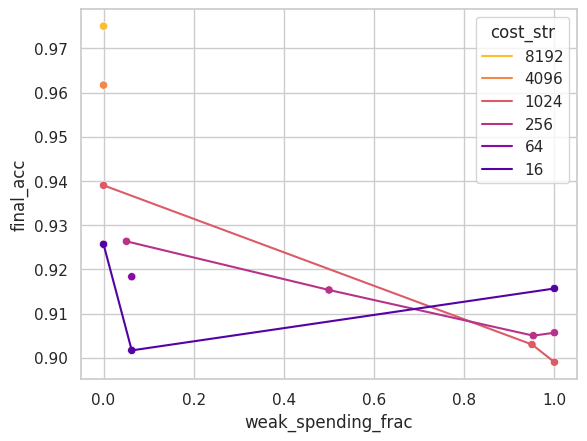

In [37]:
import seaborn as sns
sns.set_theme(style="whitegrid")
# sns.set_palette("viridis", len(runs_df["cost"].unique()))

sns.lineplot(x="weak_spending_frac", y="final_acc", hue="cost_str", data=runs_df, palette="plasma_r")
sns.scatterplot(x="weak_spending_frac", y="final_acc", hue="cost_str", data=runs_df, legend=False, palette="plasma_r")
plt.savefig("_figures/openai.pdf", bbox_inches="tight")
plt.show()

In [ ]:
from bisect import bisect_left

def get_batch_size_and_epochs(n_train):
    if n_train <= 64:
        n_epochs = 6
    if n_train <= 256:
        batch_size = 1
    elif n_train <= 1024:
        batch_size = 2
    elif n_train <= 4096:
        batch_size = 4
    elif n_train <= 8192:
        batch_size = 8
    
    return batch_size, n_epochs

In [1]:
model_id = "ft:gpt-4o-mini-2024-07-18:personal:5120-512-weak:9vwO4OYf"
model_id = "ft:gpt-4o-mini-2024-07-18:personal:5120-512-weak:9vwO4OYf"
from openai import Client

client = Client()

In [3]:
client.fine_tuning.jobs.retrieve("ftjob-KFEGvHIjy1p4GVxFwn09mauh")

FineTuningJob(id='ftjob-KFEGvHIjy1p4GVxFwn09mauh', created_at=1723593315, error=Error(code=None, message=None, param=None), fine_tuned_model='ft:gpt-4o-mini-2024-07-18:personal:5120-512-weak:9vwO4OYf', finished_at=1723596162, hyperparameters=Hyperparameters(n_epochs=3, batch_size=10, learning_rate_multiplier=1.8), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-5KzWCdbJZtVYV7zk2r3Ekq9H', result_files=['file-TjyxOGutPcUZGH7dqDn729ar'], seed=1481675480, status='succeeded', trained_tokens=1946109, training_file='file-wFm5CVakk6TrVY2s2CQyjKUH', validation_file='file-8Eo6LStbRdeZ3toHnmPiNiln', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='openai-sft', entity=None, name=None, tags=None, run_id='ftjob-KFEGvHIjy1p4GVxFwn09mauh'))], user_provided_suffix='5120-512-weak')